In [1]:
import numpy as np
import math
from GRAPE import *
import matplotlib.pyplot as plt
from qiskit import Aer, execute
import warnings
warnings.filterwarnings('ignore')

In [2]:
H = math.sqrt(0.5)*np.array([1,1,1,-1]).reshape(2,2)
X = np.array([0,1,1,0]).reshape(2,2)
Y = np.array([0,-1j,1j,0]).reshape(2,2)
Z = np.array([1,0,0,-1]).reshape(2,2)
U = np.linalg.eig(H)[1].conj().T

CX = np.eye(4)
CX[2][2] = 0
CX[3][3] = 0
CX[2][3] = 1
CX[3][2] = 1

CZ = np.eye(4)
CZ[3][3] = -1

CCZ = np.eye(8)
CCZ[7][7] = -1

TOFFOLI = np.eye(8)
TOFFOLI[6][6] = 0
TOFFOLI[7][7] = 0
TOFFOLI[6][7] = 1
TOFFOLI[7][6] = 1

U1 = np.kron(np.kron(X,U),np.eye(2))
V1 = CCZ
Ud1 = U1.conj().T

U2 = np.kron(np.kron(X,U),np.eye(2))
V2 = np.kron(CZ,np.eye(2))
Ud2 = U2.conj().T


U3 = np.kron(np.kron(np.eye(2),U),np.eye(2))
V3 = np.kron(np.eye(2),CZ)
Ud3 = U3.conj().T

U4 = np.kron(np.kron(np.eye(2),U),np.eye(2))
V4 = np.kron(CZ,np.eye(2)) @ np.kron(np.eye(2),CZ)
Ud4 = U4.conj().T

U5 = np.kron(np.kron(np.eye(2),X @ U),np.eye(2))
V5 = CCZ
Ud5 = U5.conj().T

J = np.zeros((3, 3))
J[0][1] = 0.1385
J[1][2] = 0.01304
J[0][2] = 0.00148

gates = [[U1, V1, Ud1], [U2, V2, Ud2], [U3, V3, Ud3], [U4, V4, Ud4], [U5, V5, Ud5]]
full_gates = [Ud1 @ V1 @ U1, Ud2 @ V2 @ U2, Ud3 @ V3 @ U3, Ud4 @ V4 @ U4, Ud5 @ V5 @ U5]


 1
Choose descent 52 : time=220.8419760011762, distance=(0.35097264177308674+0j)
Distance: 0.044572311131608366; Time: 220.52191127114313

 2
Choose descent 186 : time=132.63927132484793, distance=(0.5819177739777983+0j)
Distance: 0.024630557859906393; Time: 130.90074910911574

 3
Choose descent 11 : time=184.7898620236657, distance=(0.8334125418605324+0j)
Distance: 0.11433372336208514; Time: 184.84880882890786

 4
Choose descent 35 : time=116.79994994175178, distance=(0.4535623128688559+0j)
Distance: 0.04792545609967916; Time: 116.90727915071761

 5
Choose descent 114 : time=170.84053571137315, distance=(0.8975668519049242+0j)
Distance: 0.032375463661023396; Time: 172.83779547208113


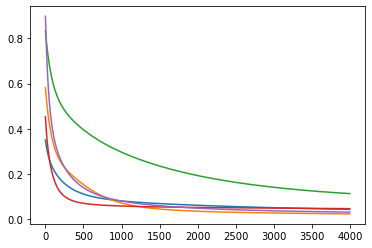

In [3]:
indices = ["U", "V", "Ud"]
for number in [1, 2, 3, 4 ,5]:
    if True:
        print("\n", number)

        n = 200
        m = 200
        k = 6

        descents = [GradientDescent(full_gates[number - 1], k) for _ in range(n)]

        for descent in descents:
            descent.noise = 1
            descent.randomize_params()
            descent.set_j(J)

        losses = [descent.descend(steps=m, track_distance=True, time_sensitive=True) for descent in descents]

        #for loss in losses:
         #   plt.plot(np.real(loss[10:]))


        t_min = 600
        p_min = -1
        for i in range(n):
            if descents[i].time < 600 and descents[i].distance < 1:
                descents[i].make_times_positive()
                if descents[i].time < t_min:
                    t_min = descents[i].time
                    p_min = i
                #print("i: ", i, " ; distance:", descents[i].distance.round(6).real, "; time:", descents[i].time.round(2))
        print(f"Choose descent {p_min} : time={descents[p_min].time}, distance={descents[p_min].distance}")


        descent = descents[p_min]

        loss = descent.descend(steps=4000, track_distance=True, time_sensitive=False)
        plt.plot(np.real(loss))

        print(f"Distance: {descent.distance.real}; Time: {descent.time.real}")
        descent.to_text(f"./Oleg/F{number}.oleg")





In [3]:
indices = ["U", "V", "Ud"]
for number in [1, 2, 3, 4, 5]:
    if True:
        descent = GradientDescent(full_gates[number - 1], filename=f"./Oleg/F{number}.oleg")
        print(f"Was :{descent.distance}")
        while descent.distance > 0.01:
            descent.descend(steps=200, track_distance=False, time_sensitive=False)
            print("Try", descent.distance)
        print(f"Now :{descent.distance}")
        descent.to_device_text(f"./Oleg/F{number}.device")

Was :(0.009992565422932042+0j)
Now :(0.009992565422932042+0j)
Was :(0.009946982943480655+0j)
Now :(0.009946982943480655+0j)
Was :(0.009714508224285925+0j)
Now :(0.009714508224285925+0j)
Was :(0.009825234095876286+0j)
Now :(0.009825234095876286+0j)
Was :(0.009967977952091749+0j)
Now :(0.009967977952091749+0j)


In [8]:
U = GradientDescent(U1, filename="./Oleg/U1.oleg")
V = GradientDescent(V1, filename="./Oleg/V1.oleg")
Ud = GradientDescent(Ud1, filename="./Oleg/Ud1.oleg")
F = GradientDescent(Ud1 @ V1 @ U1, filename="./Oleg/F1.oleg")

(Ud.matrix @ V.matrix @ U.matrix - F.matrix).round(2)

array([[-0.  +0.01j,  0.  -0.07j,  0.01+0.01j,  0.  -0.03j, -0.01+0.01j,
        -0.01+0.01j,  0.  -0.01j,  0.  +0.j  ],
       [-0.  -0.07j, -0.  -0.01j,  0.  -0.j  ,  0.  -0.01j, -0.02+0.01j,
        -0.02-0.03j, -0.  +0.01j, -0.02+0.j  ],
       [-0.01+0.01j, -0.02+0.01j, -0.  -0.01j,  0.01-0.01j, -0.01+0.j  ,
         0.  -0.j  ,  0.02+0.01j,  0.01+0.02j],
       [ 0.  -0.03j,  0.  +0.01j,  0.02+0.01j,  0.  -0.01j,  0.01+0.02j,
        -0.  -0.02j,  0.01-0.01j,  0.02+0.01j],
       [ 0.01+0.01j,  0.01+0.02j,  0.01+0.01j,  0.02-0.01j, -0.  +0.01j,
         0.  +0.06j,  0.  +0.01j,  0.04-0.03j],
       [ 0.01+0.01j,  0.02-0.04j, -0.  -0.j  ,  0.02-0.j  , -0.  +0.06j,
        -0.  -0.01j, -0.04+0.03j, -0.01-0.01j],
       [-0.  -0.01j, -0.  +0.01j, -0.02+0.01j,  0.01+0.02j, -0.  +0.01j,
         0.04+0.03j, -0.  -0.01j, -0.01+0.04j],
       [-0.  +0.j  ,  0.  +0.01j, -0.01+0.01j,  0.03-0.01j, -0.04-0.03j,
         0.01-0.01j,  0.01+0.04j, -0.  +0.01j]])